In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.append("../")

import cusp_encounters.cusp_distribution as cd
import cusp_encounters.encounters_math as em
import cusp_encounters.cored_powerlaw as cp

sys.path.append("../adiabatic-tides")
import adiabatic_tides as at

cachedir = "../caches"

%load_ext autoreload

In [2]:
class ShockedCuspProfile(at.profiles.NumericalProfile):
    """This is the profile of a prompt cusp -- powerlaw plus the truncation from a stellar encounter"""
    def __init__(self, A, rB=1.):
        self.rB = rB
        
        self.base_powerlaw = at.profiles.PowerlawProfile(rhoc=A, rscale=1., slope=-1.5)
        
        ri = np.logspace(-20,20, 10000) * self.rB
        rhoi = self.density_transfer_function(ri)*self.base_powerlaw.density(ri)
        
        self.phirB = self.base_powerlaw.potential(rB)
        self.EcircB = 0.5*self.base_powerlaw.vcirc(rB)**2
        self.lamB = np.abs(self.base_powerlaw.accr(rB) / rB)
        
        super().__init__(ri=ri, rhoi=rhoi, r0=rB, ancorphi="rmin")
        
    def _initialize_numerical_scales(self):
        """Sets some default values for numerical scales"""
        
        super()._initialize_numerical_scales()
        
        self._sc["fintegration_nstepsE"] = 501
        self._sc["fintegration_nstepsL"] = 201
        #self._sc["fintegration_nstepsE"] = 201
        #self._sc["fintegration_nstepsL"] = 101
        self._sc["ip_e_of_jl_nbinsE"] = 2000
        #self._sc["ip_e_of_jl_nbinsE"] = 1000
        self._sc["ip_e_of_jl_nbinsL"] = 200
        #self._sc["ip_e_of_jl_nbinsL"] = 100

        self._sc["log_emin"] = -18
        self._sc["rmin"] = self.r0() * 1e-12
        self._sc["rperimin"] = self.r0() * 1e-12

        self._sc["niter_apoperi"] = 35
        
    def density_transfer_function(self, r, alpha=1.243, beta=0.637):
        return np.exp(- alpha * (r/self.rB)**beta)
    
sprof = ShockedCuspProfile(A=1.)

# Check Iteration Convergence

In [3]:
aprof1 = at.profiles.AdiabaticProfile(prof_initial=sprof, tide=sprof.lamB*1e-2, niter=20, verbose=0, h5cache="../caches/stripped_shocked_cusp.hdf5", store_every_step=True)
aprof2 = at.profiles.AdiabaticProfile(prof_initial=sprof, tide=sprof.lamB*1e1, niter=20, verbose=0, h5cache="../caches/stripped_shocked_cusp.hdf5", store_every_step=True)

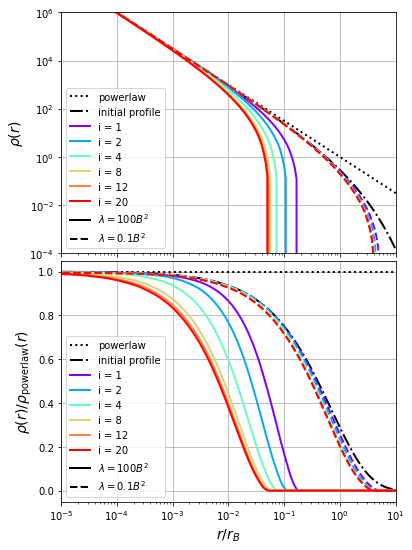

In [4]:
fig, axs = plt.subplots(2,1, figsize=(6,9), sharex=True)
fig.subplots_adjust(hspace=0.03)

ri = np.logspace(-8,3, 400)

axs[0].loglog(ri, sprof.base_powerlaw.density(ri), lw=2, color="black", linestyle="dotted", label="powerlaw")
axs[0].loglog(ri, sprof.density(ri), lw=2, color="black", linestyle="-.", label="initial profile")
axs[1].semilogx(ri, sprof.base_powerlaw.density(ri) / sprof.base_powerlaw.density(ri), lw=2, color="black", linestyle="dotted", label="powerlaw")
axs[1].semilogx(ri, sprof.density(ri) / sprof.base_powerlaw.density(ri), lw=2, color="black", linestyle="-.", label="initial profile")

for i in (1,2,4,8,12,20):#,32,64
    for lam,label,linestyle in (1e1,"i = %d" % i,"solid"), (1e-2,None, "dashed"):
        prof_ad = at.profiles.AdiabaticProfile(prof_initial=sprof, tide=sprof.lamB*lam, niter=i, verbose=0, h5cache="../caches/stripped_shocked_cusp.hdf5", store_every_step=True)
        #color = plt.get_cmap("viridis")(i/5.)
        color =plt.get_cmap("rainbow")(np.log10(i)/np.log10(20.))
        axs[0].loglog(ri, prof_ad.self_density(ri), lw=2, color=color, label=label, linestyle=linestyle)
        axs[1].semilogx(ri, prof_ad.self_density(ri) / sprof.base_powerlaw.density(ri), lw=2, color=color, label=label, linestyle=linestyle)
    

axs[0].set_ylim(1e-4,1e6)

axs[0].set_ylabel(r"$\rho(r)$", fontsize=14)
axs[1].set_ylabel(r"$\rho(r) / \rho_{\rm{powerlaw}}(r)$", fontsize=14)
axs[1].set_xlabel(r"$r/r_{B}$", fontsize=14)
    
for ax in axs:
    ax.plot([],ls="solid",lw=2, label=r"$\lambda = 100 B^2$", color="black")
    ax.plot([],ls="dashed",lw=2, label=r"$\lambda = 0.1 B^2$", color="black")
    
    ax.grid("on")
    ax.set_xlim(1e-5,1e1)
    ax.legend()
    
plt.savefig("img/atides_iteration_convergence.pdf", bbox_inches="tight")

# Check density profiles versus shock strength

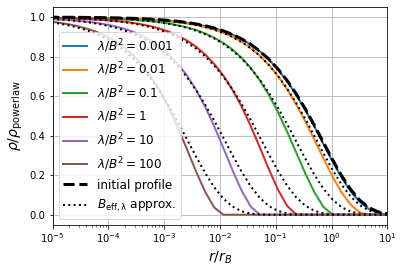

In [5]:
niter = 30
aprofpow = at.profiles.AdiabaticProfile(prof_initial=sprof.base_powerlaw, tide=sprof.lamB, niter=niter, nbins=250, verbose=0, h5cache="../caches/stripped_shocked_cusp.hdf5")

ri = np.logspace(-7, 1)
for lfac in 1e-3,1e-2,1e-1,1e0,1e1,1e2:
    aprof = at.profiles.AdiabaticProfile(prof_initial=sprof, tide=sprof.lamB*lfac, niter=niter, nbins=250, verbose=0, h5cache="../caches/stripped_shocked_cusp.hdf5")
    
    plt.semilogx(ri, aprof.self_density(ri) / sprof.base_powerlaw.density(ri), label=r"$\lambda / B^2 = %g$" % lfac, lw=2)

    A, p = 1., 2.
    B = ((8.*np.pi*sprof.G*A)/(3.))**0.5
    Beff = B * (1. + (42.17*lfac)**(p/2.))**(1./p)
    rBeff = ((8.*np.pi*sprof.G*A)/(3.*Beff**2))**(2./3.)
        
    alpha, beta = 1.243, 0.637
    plt.plot(ri, np.exp(- alpha * (ri/rBeff)**beta), color="black", linestyle="dotted", lw=2)

plt.semilogx(ri, sprof.self_density(ri) / sprof.base_powerlaw.density(ri), linestyle="dashed", color="black", lw=3, label="initial profile")
plt.xlim(1e-5,1e1)
plt.grid("on")
plt.xlabel(r"$r / r_B$", fontsize=14)

plt.plot([], color="black", linestyle="dotted", lw=2, zorder=5, label=r"$B_{\rm{eff},\lambda}$ approx.")
plt.ylabel(r"$\rho / \rho_{\rm{powerlaw}}$", fontsize=14)

plt.legend(loc="lower left", fontsize=12)
plt.savefig("img/tides_transfer.pdf", bbox_inches="tight")

In [6]:
niter = 30
lfacs = np.array((1e-3,3e-3,1e-2,3e-2,1e-1,3e-1,1e0,1e1,1e2))
Js = []
for lfac in lfacs:
    aprof = at.profiles.AdiabaticProfile(prof_initial=sprof, tide=sprof.lamB*lfac, niter=niter, nbins=250, verbose=0, h5cache="../caches/stripped_shocked_cusp.hdf5")
    Js.append(aprof.integral_density_squared(rmin=1e-6, rmax=1e2))

In [7]:
def Jpowerlaw_atides(lfac, rmin=1e-6):
    Jpow_base = aprofpow.integral_density_squared(rmin=1e-6, rmax=1e2)
    rt0 = lfac**(-2./3.)
    
    #return Jpow_base + 4.*np.pi*sprof.base_powerlaw.rhoc * np.log(1e-6*rt0 / rmin)
    return 4.*np.pi * np.log(7.759e-3 * rt0 / rmin)

def Jpow_effective(lfac, rmin=1e-6):
    G = sprof.G
    A = 1.
    B = ((8.*np.pi*G*A)/(3.))**0.5
    
    p = 2.
    
    Beff = B * (1.**p + (42.17*lfac)**(p/2.))**(1./p)
    
    rB = ((8.*np.pi*G*A)/(3.*Beff**2))**(2./3.)
    
    return 4*np.pi*A**2 * np.log(0.094*rB/rmin)

In [8]:
Jpow_base = aprofpow.integral_density_squared(rmin=1e-6, rmax=1e2)
print(np.exp(Jpow_base/(4.*np.pi) + np.log(1e-6)))
print((0.094 / 7.759e-3)**1.5)

0.007759279505027321
42.1680145051359


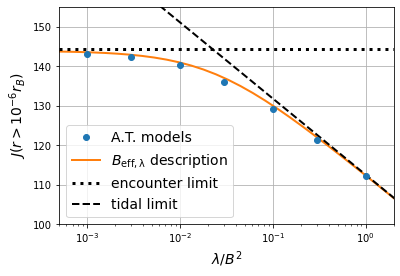

In [9]:
plt.semilogx(lfacs, Js, marker="o", linestyle="None", label="A.T. models", zorder=3)
#plt.semilogx(lfacs, Jpowerlaw_transition(lfacs))
lfacev = np.logspace(-4,2.5)
plt.semilogx(lfacev, Jpow_effective(lfacev), label=r"$B_{\rm{eff},\lambda}$ description", lw=2)
plt.axhline(sprof.integral_density_squared(rmin=1e-6, rmax=1e2), color="black", linestyle="dotted", lw=3, label="encounter limit")
plt.semilogx(lfacs, Jpowerlaw_atides(lfacs), linestyle="dashed", color="black", label="tidal limit", lw=2)
plt.xlim(5e-4, 2e0)
plt.ylim(100,155)
plt.ylabel(r"$J (r > 10^{-6} r_B)$", fontsize=14)
plt.xlabel(r"$\lambda / B^2$", fontsize=14)
plt.grid("on")
plt.legend(loc="lower left", fontsize=14)
plt.savefig("img/tides_Jfactor.pdf", bbox_inches="tight")

# Check whether this also works for cored cusps

In [10]:
cprof = cp.PhasespaceTruncatedCusp(A=1., rcore=1., rmin=1e-5, rmax=1e8)
B = ((8.*np.pi*cprof.G*cprof.A)/(3.*np.pi))**0.5
lamdis = (0.66*B)**2 /42.
aprof1 = at.profiles.AdiabaticProfile(prof_initial=cprof, tide=lamdis*1e-4, niter=31, nbins=250, rmin=1e-3, rmax=1e8,verbose=1, h5cache="../caches/stripped_shocked_cusp.hdf5", store_every_step=True)
aprof2 = at.profiles.AdiabaticProfile(prof_initial=cprof, tide=lamdis*4e-1, niter=31, nbins=250, rmin=1e-3, rmax=1e8,verbose=1, h5cache="../caches/stripped_shocked_cusp.hdf5", store_every_step=True)

Reading result of previous calculation from ../caches/stripped_shocked_cusp.hdf5 (i=31)
Reading result of previous calculation from ../caches/stripped_shocked_cusp.hdf5 (i=31)


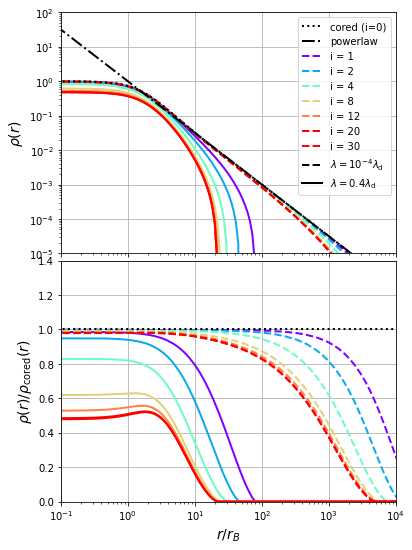

In [11]:
fig, axs = plt.subplots(2,1, figsize=(6,9), sharex=True)
fig.subplots_adjust(hspace=0.03)

ri = np.logspace(-8,6, 400)

axs[0].loglog(ri, cprof.density(ri), lw=2, color="black", linestyle="dotted", label="cored (i=0)", zorder=10)
axs[0].loglog(ri, cprof.base_powerlaw.density(ri), lw=2, color="black", linestyle="-.", label="powerlaw", zorder=10)
axs[1].semilogx(ri, cprof.base_powerlaw.density(ri) / cprof.base_powerlaw.density(ri), lw=2, color="black", linestyle="dotted", label="cored (i=0)", zorder=10)

for i in (1,2,4,8,12,20,30):#8,12,20,32,64
    for lam,label,linestyle in (1e-4,"i = %d" % i,"dashed"), (4e-1,None, "solid"):
        prof_ad = at.profiles.AdiabaticProfile(prof_initial=cprof, tide=lamdis*lam, nbins=250, rmin=1e-3, rmax=1e8, niter=i, verbose=0, h5cache="../caches/stripped_shocked_cusp.hdf5", store_every_step=True)
        #color = plt.get_cmap("viridis")(i/5.)
        color =plt.get_cmap("rainbow")(np.log10(i)/np.log10(20.))
        axs[0].loglog(ri, prof_ad.self_density(ri), lw=2, color=color, label=label, linestyle=linestyle)
        axs[1].semilogx(ri, prof_ad.self_density(ri) / cprof.density(ri), lw=2, color=color, label=label, linestyle=linestyle)
    

axs[0].set_ylim(1e-5,1e2)

axs[0].set_ylabel(r"$\rho(r)$", fontsize=14)
axs[1].set_ylabel(r"$\rho(r) / \rho_{\rm{cored}}(r)$", fontsize=14)
axs[1].set_xlabel(r"$r/r_{B}$", fontsize=14)
    
axs[1].set_ylim(0.,1.4)

for ax in axs:
    ax.plot([],ls="dashed",lw=2, label=r"$\lambda = 10^{-4} \lambda_{\rm{d}}$", color="black")
    ax.plot([],ls="solid",lw=2, label=r"$\lambda = 0.4 \lambda_{\rm{d}}$", color="black")
    
    ax.grid("on")
    ax.set_xlim(1e-1,1e4)
    
axs[0].legend()    
    
plt.savefig("img/cored_atides_iteration_convergence.pdf", bbox_inches="tight")

# profiles and J factors

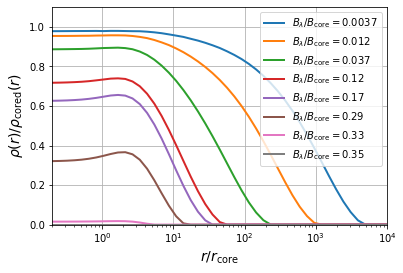

In [12]:
cprof = cp.PhasespaceTruncatedCusp(A=1., rcore=1., rmin=1e-5, rmax=1e8)
Bref = ((8.*np.pi*cprof.G*cprof.A)/(3.*np.pi))**0.5
lamdis = (0.66*Bref)**2 /42.
Bcore = ((8.*np.pi*cprof.G*cprof.A)/(3.))**0.5
niter = 30

#for lfac in 1e-4,3e-4,1e-3,3e-3,1e-2,3e-2,0.1,0.2,0.4,0.6,0.8,0.9,1.0:
for lfac in 1e-4,1e-3,1e-2,0.1,0.2,0.6,0.8,0.9:
    aprof = at.profiles.AdiabaticProfile(prof_initial=cprof, tide=lamdis*lfac, nbins=250, rmin=1e-3, rmax=1e8, niter=niter, h5cache="../caches/stripped_shocked_cusp.hdf5")
    
    Blam = np.sqrt(42.2 * lfac*lamdis)
    ri = np.logspace(-1,4)
    plt.semilogx(ri, aprof.self_density(ri) / cprof.density(ri), label=r"$B_{\lambda} / B_{\rm{core}} = %.2g$" % (Blam/Bcore), lw=2)
    
plt.legend()
plt.grid()
plt.xlim(0.2, 1e4)
plt.ylim(0.,1.1)
plt.ylabel(r"$\rho(r) / \rho_{\rm{cored}}(r)$", fontsize=14)
plt.xlabel(r"$r / r_{\rm{core}}$", fontsize=14)
plt.savefig(r"img/cored_smooth_tide_transfer.pdf", bbox_inches="tight")

In [13]:
lfacs = np.array((1e-4,3e-4,1e-3,3e-3,1e-2,3e-2,0.1,0.2,0.4,0.6,0.8,0.9,1.0))
Js = []
for lfac in lfacs:
    aprof = at.profiles.AdiabaticProfile(prof_initial=cprof, tide=lamdis*lfac, nbins=250, rmin=1e-3, rmax=1e8, niter=niter, verbose=0, h5cache="../caches/stripped_shocked_cusp.hdf5")
    Js.append(aprof.integral_density_squared(rmin=1e-3, rmax=1e5))

Js = np.array(Js)

In [14]:
#rcore = 1
Bref = ((8.*np.pi*cprof.G*cprof.A)/(3.*np.pi))**0.5
lamdis = (0.66*Bref)**2 /42.
Bcore = ((8.*np.pi*cprof.G*cprof.A)/(3.))**0.5

Blam = np.sqrt(42.2 * lfacs*lamdis)
Bcusp = Bcore / 10000. # does not matter here

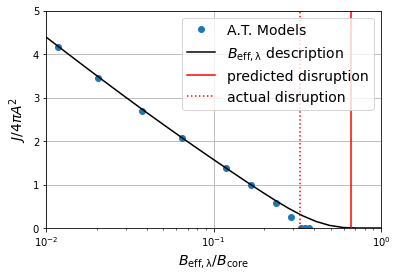

In [15]:
plt.semilogx(Blam/Bcore,Js / (4.*np.pi), marker="o", linestyle="none", label="A.T. Models")

Bsref = np.logspace(-3, 1) * Bcore
plt.semilogx(Bsref/Bcore,em.Jcorecusp_in_4piA2(Bsref, Bcore=Bcore, Bcusp=Bcusp), label=r"$B_{\rm{eff},\lambda}$ description", color="black")
plt.axvline(0.66, label="predicted disruption", color="red")
plt.axvline(0.33, label="actual disruption", color="red", linestyle="dotted")

plt.xlabel(r"$B_{\rm{eff},\lambda} / B_{\rm{core}}$", fontsize=14)
plt.ylabel(r"$J / 4 \pi A^2$", fontsize=14)
plt.grid()
plt.xlim(1e-2,1e0)
plt.ylim(0,5)
plt.legend(fontsize=14, loc="upper right")

plt.savefig("img/Jcore_smooth_tides.pdf", bbox_inches="tight")